In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.2
    Uninstalling scipy-1.11.2:
      Successfully uninstalled scipy-1.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.9.0 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 2.0.2 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.3 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you h

In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import os
from sklearn.utils import shuffle
from tensorflow.keras import layers, models

D1004 04:52:21.413962995      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1004 04:52:21.413988793      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1004 04:52:21.413992067      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1004 04:52:21.413994509      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1004 04:52:21.413996688      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1004 04:52:21.413999218      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1004 04:52:21.414001505      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1004 04:52:21.

In [2]:
import pickle
import gc

In [3]:
import random

In [12]:
import matplotlib.pyplot as plt

def show_images_side_by_side(image1, image2, title1='Image 1', title2='Image 2'):
    """
    Display two images side by side in the same frame.

    Parameters:
    - image1: NumPy array, the first image to be displayed.
    - image2: NumPy array, the second image to be displayed.
    - title1: str, title for the first image (default: 'Image 1').
    - title2: str, title for the second image (default: 'Image 2').
    """

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image
    axs[0].imshow(image1, cmap='gray')  # Assuming images are grayscale, adjust cmap if needed
    axs[0].set_title(title1)
    axs[0].axis('off')

    # Display the second image
    axs[1].imshow(image2, cmap='gray')
    axs[1].set_title(title2)
    axs[1].axis('off')

    # Show the plot
    plt.show()

In [3]:
def residual_block(x, filters, kernel_size=3, strides=1):
    # Shortcut
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adjust the shortcut connection to match the number of channels
    if strides > 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Adding the shortcut to the main path
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [4]:
def create_resnet_autoencoder(input_shape=(1024, 768, 1)):
    # Encoder
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy =tf.distribute.TPUStrategy(tpu)
#     strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        input_img = tf.keras.layers.Input(shape=input_shape)

        x = residual_block(input_img, filters=128)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)

        encoded = residual_block(x, filters=256)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)

        # Decoder
        
        x = residual_block(x, filters=256)
        x = layers.UpSampling2D((2, 2))(x)

        x = residual_block(x, filters=128)
        x = layers.UpSampling2D((2, 2))(x)

        decoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

        # Create the autoencoder model
        autoencoder = tf.keras.models.Model(input_img, decoded)

        # Compile the model
        autoencoder.compile(optimizer='adam', loss='mse')  # Use 'mse' for grayscale images

    return autoencoder

In [4]:
def create_autoencoder(input_shape=(1024, 768, 1)):
    # Encoder
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        input_img = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

        # Add more convolutional layers with skip connections in the encoder
        x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        skip_1 = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(skip_1)

        # Decoder with skip connections
        x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        x = tf.keras.layers.Concatenate()([x, skip_1])  # Skip connection
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

        # Create the autoencoder model
        autoencoder = tf.keras.models.Model(input_img, decoded)

        # Compile the model
        autoencoder.compile(optimizer='adam', loss='mse')  # Use 'mse' for grayscale images

    return autoencoder

In [3]:
def create_simple_autoencoder(input_shape=(1024, 768, 1)):
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy =tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        # Encoder
        input_img = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        encoded = tf.keras.layers.BatchNormalization()(x)
        # Decoder
        
        
        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

        # Create the autoencoder model
        autoencoder = tf.keras.models.Model(input_img, decoded)

        # Compile the model
        autoencoder.compile(optimizer='adam', loss='mse')  # Use 'mse' for grayscale images

    return autoencoder

In [6]:
def create_oneLayour_autoencoder(input_shape=(1024, 768, 1)):
    strategy = tf.distribute.MirroredStrategy()
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     strategy =tf.distribute.experimental.TPUStrategy(tpu)
    with strategy.scope():
        input_img = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
        x = tf.keras.layers.BatchNormalization()(x)
        encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)

        decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

        # Create the autoencoder model
        autoencoder = tf.keras.models.Model(input_img, decoded)

        # Compile the model
        autoencoder.compile(optimizer='adam', loss='mse')  # Use 'mse' for grayscale images

    return autoencoder
        

In [5]:
def load_images(path):
    # Extract the file name from the path
    filename = os.path.split(path)[1]
    
    # Extract the label from the filename
    label = filename.split("_")[:-1]
    
    # Create the target path
    target_path = os.path.join("/kaggle/input/idp-shabby/clean/clean", "_".join(label) + ".png")
    
    # Load the images using PIL
    ximg = Image.open(path)
    yimg = Image.open(target_path)
    
    # Convert images to arrays
    
    # Resize images
    ximg = ximg.resize((768, 1024),Image.Resampling.LANCZOS)
    yimg = yimg.resize((768, 1024),Image.Resampling.LANCZOS)
    
    # Convert images to grayscale
    xgrayscale_image = np.array(ximg.convert('L'))
    ygrayscale_image = np.array(yimg.convert('L'))
    
    return xgrayscale_image, ygrayscale_image

In [11]:
data_folder = '/kaggle/input/idp-shabby/shabby/shabby'

# Get a list of all image file paths
image_paths = [os.path.join(data_folder, filename) for filename in os.listdir(data_folder) if filename.endswith('.png')]

# Split the dataset into training and validation sets
train_paths= shuffle(image_paths,random_state=42)
l=len(train_paths)
l16=l//20
count=1
train_x=[]
train_y=[]
lowerBound=l16*count
upperBound=min(l,l16*(count+1))
for i in range(lowerBound,upperBound):
    path=train_paths[i]
    x,y=load_images(path)
    train_x.append(x)
    train_y.append(y)
    print('train:',i/upperBound,"of",upperBound-lowerBound,upperBound, end="\r")
train_x=np.array(train_x)
train_y=np.array(train_y)
val_x=[]
val_y=[]
count+=1
lowerBound=l16*count
upperBound=min(l,l16*(count+1))
for i in range(lowerBound,upperBound):
    path=train_paths[i]
    x,y=load_images(path)
    val_x.append(x)
    val_y.append(y)
    print('val:',i/upperBound, "of",upperBound-lowerBound,upperBound,end="\r")
val_x=np.array(val_x)
val_y=np.array(val_y)

In [ ]:
count=0
for path in val_paths:
    x,y=load_images(path)
    val_x.append(x)
    val_y.append(y)
    count+=1
    print("val:",count/len(val_paths),end="\r")

val_x=np.array(val_x)
val_y=np.array(val_y)

In [2]:
val_x.shape

NameError: name 'val_x' is not defined

In [6]:
with open('/kaggle/input/train-paths-idp/train_path.pkl', 'rb') as file:
    # Load the data from the file
    train_paths = pickle.load(file)
file.close()

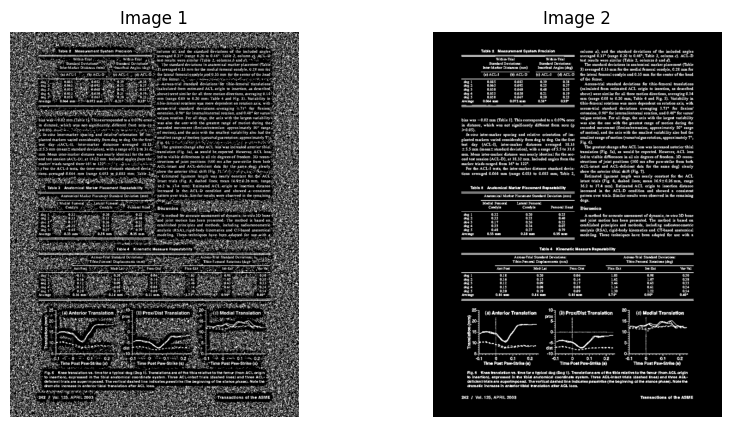

In [14]:
random_element = random.choice(train_paths)
x,y = load_images(random_element)
show_images_side_by_side(x,y)

In [7]:
autoencoder=create_resnet_autoencoder()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [10]:
l=len(train_paths)
l16=l//10
count=0
while True:
    train_x=[]
    train_y=[]
    lowerBound=l16*count
    upperBound=min(l,l16*(count+1))
    for i in range(lowerBound,upperBound):
        path=train_paths[i]
        x,y=load_images(path)
        train_x.append(x)
        train_y.append(y)
        print('train:',(i-lowerBound)/(upperBound-lowerBound),"of",upperBound-lowerBound,upperBound,"     " ,end="\r")
    train_x=np.array(train_x)
    train_y=np.array(train_y)
    val_x=[]
    val_y=[]
    count+=1
    lowerBound=l16*count
    upperBound=min(l,l16*(count+1))
    for i in range(lowerBound,upperBound):
        path=train_paths[i]
        x,y=load_images(path)
        val_x.append(x)
        val_y.append(y)
        print('val:',(i-lowerBound)/(upperBound-lowerBound), "of",upperBound-lowerBound,upperBound,"     " ,end="\r")
    val_x=np.array(val_x)
    val_y=np.array(val_y)
    autoencoder.fit(train_x,train_y,epochs=10,batch_size=32,validation_data=(val_x,val_y))
    del train_x,train_y,val_x,val_y
    gc.collect()
    autoencoder.save('/kaggle/working/autoenc_relu1024res_t4_1.keras')
    if upperBound==l:
        break

KeyboardInterrupt: 

In [8]:
l=len(train_paths)
l16=l
count=0
train_x=[]
train_y=[]
lowerBound=l16*count
upperBound=min(l,l16*(count+1))
while True:
    for i in range(lowerBound,upperBound):
        path=train_paths[i]
        x,y=load_images(path)
        train_x.append(x)
        train_y.append(y)
        print('train:',(i-lowerBound)/(upperBound-lowerBound),"of",upperBound-lowerBound,upperBound,"     " ,end="\r")
    train_x=np.array(train_x)
    train_y=np.array(train_y)
    autoencoder.fit(train_x,train_y,epochs=20,batch_size=32,validation_split=0.1)
    del train_x,train_y
    gc.collect()
    autoencoder.save('/kaggle/working/autoenc_relu1024res_t4_1.keras')

Epoch 1/2099722914934885 of 3609 3609          


2023-10-04 04:57:43.765590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-04 04:57:43.951708: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


102/102 [==============================] - ETA: 0s - loss: 2367.6360

2023-10-04 04:59:42.127272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-04 04:59:42.235437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


102/102 [==============================] - 163s 1s/step - loss: 2367.6360 - val_loss: 2470.8140
Epoch 2/20
102/102 [==============================] - 71s 700ms/step - loss: 2119.2869 - val_loss: 2355.1433
Epoch 3/20
102/102 [==============================] - 71s 700ms/step - loss: 1993.8005 - val_loss: 2236.2251
Epoch 4/20
102/102 [==============================] - 72s 701ms/step - loss: 1904.9552 - val_loss: 2414.8848
Epoch 5/20
102/102 [==============================] - 71s 701ms/step - loss: 1855.5999 - val_loss: 1956.7567
Epoch 6/20
102/102 [==============================] - 71s 701ms/step - loss: 1815.6121 - val_loss: 2292.4448
Epoch 7/20
102/102 [==============================] - 71s 701ms/step - loss: 1791.8988 - val_loss: 2065.3164
Epoch 8/20
102/102 [==============================] - 71s 701ms/step - loss: 1769.4946 - val_loss: 1968.0414
Epoch 9/20
102/102 [==============================] - 72s 702ms/step - loss: 1742.5190 - val_loss: 2208.1304
Epoch 10/20
102/102 [===========

NameError: name 'train_x' is not defined

In [9]:
autoencoder.save('/kaggle/working/autoenc_relu1024res_T4_2_final.keras')

In [21]:
gc.collect()

1946

In [7]:
autoencoder=create_autoencoder()
autoencoder.fit(train_x,train_y,epochs=5,batch_size=1,validation_data=(val_x,val_y))

Epoch 1/5
180/180 [==============================] - 32s 107ms/step - loss: 0.1902 - val_loss: 0.5358
Epoch 2/5
180/180 [==============================] - 17s 93ms/step - loss: 0.0537 - val_loss: 0.1089
Epoch 3/5
180/180 [==============================] - 17s 92ms/step - loss: 0.0496 - val_loss: 0.0515
Epoch 4/5
180/180 [==============================] - 15s 86ms/step - loss: 0.0496 - val_loss: 0.0667
Epoch 5/5
180/180 [==============================] - 15s 86ms/step - loss: 0.0466 - val_loss: 0.1072


In [8]:
model_path = '/kaggle/input/autoenc-std-idp/autoencstd.keras'
autoencoder = keras.models.load_model(model_path)

OSError: No file or directory found at /kaggle/input/autoenc-std-idp/autoencstd_l.keras

In [17]:
autoencoder.fit(train_x,train_y,epochs=5,batch_size=1,validation_data=(val_x,val_y))

Epoch 1/5
180/180 [==============================] - 19s 107ms/step - loss: 0.0442 - val_loss: 0.0586
Epoch 2/5
180/180 [==============================] - 17s 94ms/step - loss: 0.0442 - val_loss: 0.0428
Epoch 3/5
180/180 [==============================] - 17s 93ms/step - loss: 0.0433 - val_loss: 0.0441
Epoch 4/5
180/180 [==============================] - 16s 87ms/step - loss: 0.0485 - val_loss: 0.0403
Epoch 5/5
180/180 [==============================] - 17s 93ms/step - loss: 0.0450 - val_loss: 0.2803


In [9]:
with open("/kaggle/working/train_path.pkl",'wb') as file:
    pickle.dump(train_paths,file)
file.close()

In [18]:
autoencoder.save('/kaggle/working/autoencstd_l1.keras')

In [20]:
del train_x,train_y,val_x,val_y

NameError: name 'train_x' is not defined